In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

# Analysis of the effect of before/after an election

In [3]:
src = "../data/processed"
dst = "../results"
plt_dst = "../plots"

## Create candidate information table

In [4]:
fname = "study_data.csv.gzip"
tweets = pd.read_csv(
    Path(src, fname),
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at", "ELECTIONDATE"],
    compression="gzip"
)

In [5]:
candidates = tweets[["handle", "PARTY", "ELECTIONDATE", "id"]]\
    .groupby(["handle", "PARTY", "ELECTIONDATE"])\
    .count()\
    .rename(columns={"id":"N_tweets"})\
    .reset_index()
candidates = candidates.set_index(["handle", "ELECTIONDATE"])
candidates.head(3)

,,PARTY,N_tweets
handle,ELECTIONDATE,,
1haywood,2022-05-17,R,3
aarikarhodes,2022-06-07,D,95
aazamishervin,2022-06-07,D,154


In [6]:
candidates["N_tweets_before"] = 0
candidates["N_tweets_after"] = 0
for handle, electiondate in candidates.index:
    # select only tweets of the candidate from the four weeks before and after 
    # the election date
    candidate_tweets = tweets[tweets["handle"] == handle]
    candidate_tweets_before = candidate_tweets[
        (candidate_tweets["created_at"].dt.date <= electiondate.date()) & \
        (candidate_tweets["created_at"].dt.date >= electiondate.date() - pd.Timedelta(days=28))
    ]
    candidate_tweets_after = candidate_tweets[
        (candidate_tweets["created_at"].dt.date > electiondate.date()) & \
        (candidate_tweets["created_at"].dt.date <= electiondate.date() + pd.Timedelta(days=28))
    ]
    candidates.loc[(handle, electiondate), "N_tweets_before"] = len(candidate_tweets_before)
    candidates.loc[(handle, electiondate), "N_tweets_after"] = len(candidate_tweets_after)
candidates.head(3)

,,PARTY,N_tweets,N_tweets_before,N_tweets_after
handle,ELECTIONDATE,,,,
1haywood,2022-05-17,R,3,2,1
aarikarhodes,2022-06-07,D,95,73,22
aazamishervin,2022-06-07,D,154,118,36


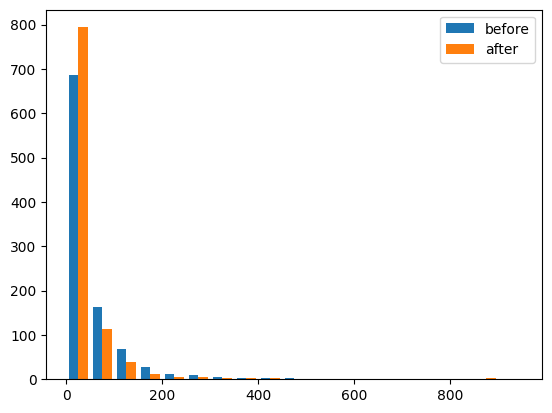

In [7]:
fig, ax = plt.subplots()
ax.hist([candidates["N_tweets_before"], candidates["N_tweets_after"]],
        bins=range(0, 1000, 50), rwidth=0.8, label=["before", "after"])
ax.legend();

## Power analysis belief-speaking

### Linear mixed-effects model simulations

In [8]:
# define simulation parameters
n_sim = 200  # Number of simulations
alpha = 0.05  # Significance level

# sample sizes
n_groups = len(candidates)
n_democrats = len(candidates[candidates["PARTY"] == "D"])
mean_tweets_before = candidates["N_tweets_before"].mean()
mean_tweets_after = candidates["N_tweets_after"].mean()

# variance components - from script estimate_variance_factors_pilot_data.ipynb
variance_components = {}
fname = "variance_components_election_analysis_belief_speaking.txt"
with open(Path(dst, "variance_components", fname), "r") as infile:
    for line in infile:
        key, val = line.rstrip().split("=")
        variance_components[key] = float(val)
    
var_intercept = variance_components["var_intercept"]
var_slope_E = variance_components["var_slope_E"]
cov_intercept_slope_E = variance_components["cov_intercept_slope_E"]
var_residual = variance_components["var_residual"]

In [9]:
def simulate_lme(params):
    random_state, beta_E, beta_P, beta_EP = params
    
    n_obs_per_group_before = candidates["N_tweets_before"]\
        .sample(n_groups, random_state=random_state)\
        .values.astype(int)
    mean_tweets_before = n_obs_per_group_before.mean()
    
    n_obs_per_group_after = candidates["N_tweets_after"]\
        .sample(n_groups, random_state=random_state)\
        .values.astype(int)
    mean_tweets_before = n_obs_per_group_after.mean()
    
    total_n = n_obs_per_group_before.sum() + n_obs_per_group_after.sum()
    
    # generate simulated data
    group = np.repeat(np.arange(n_groups), n_obs_per_group_before + n_obs_per_group_after)

    # binary predictor P sampled from distribution of party affiliations
    P_group = np.random.binomial(1, n_democrats/ n_groups, n_groups)
    P_observations = np.repeat(P_group, n_obs_per_group_before + n_obs_per_group_after)

    # binary predictor E sampled from distribution of before / after election tweets
    E = np.random.binomial(1, mean_tweets_before / (mean_tweets_before + mean_tweets_after), total_n)  
    
    # random effects
    mean = [0, 0]
    cov = [[var_intercept, cov_intercept_slope_E],
           [cov_intercept_slope_E, var_slope_E]]
    random_effects = np.random.multivariate_normal(mean, cov, n_groups)
    random_intercepts = random_effects[:, 0][group]
    random_slopes_E = random_effects[:, 1][group]
    errors = np.random.normal(0, np.sqrt(var_residual), total_n)

    # calculate dependent variable
    D = (0 + \
         (beta_E + random_slopes_E) * E + \
         beta_P * P_observations + \
         beta_EP * E * P_observations + \
         random_intercepts + errors)
    data = pd.DataFrame({'D':D, 'C':group, 'P':P_observations, 'E':E})

    # fit the linear mixed effects model
    model = smf.mixedlm(
        "D ~ E * P", 
        data, 
        groups=data["C"],
        re_formula="1 + E"
    )
    result = model.fit()

    # assess significance of the effects, handle cases where the term is not estimable
    try:
        p_value_interaction = result.pvalues['E:P']
    except KeyError:
        p_value_interaction = np.nan
    try:
        p_value_P = result.pvalues['P']
    except KeyError:
        p_value_P = np.nan
    try:
        p_value_E = result.pvalues['E']
    except KeyError:
        p_value_E = np.nan

    return (random_state, beta_E, beta_P, beta_EP, p_value_E, p_value_P, p_value_interaction)

In [10]:
# effect sizes that will be simulated
beta_Es = [0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016]
beta_Ps = [0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016]
beta_EPs = [0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016]
random_states = range(n_sim)

params = [(i, beta_Es[j], beta_Ps[j], beta_EPs[j])\
              for j in range(len(beta_Es))\
              for i in random_states] 
N_configs = len(params)

In [ ]:
results = pd.DataFrame()
pool = Pool(10)

for tmp1, tmp2, tmp3, tmp4, tmp5, tmp6, tmp7 in tqdm(pool.imap_unordered(
    func=simulate_lme, 
    iterable=params), 
    total=N_configs):

    results = pd.concat([results, pd.DataFrame({
        "random_state":[tmp1],
        "beta_E":[tmp2],
        "beta_P":[tmp3],
        "beta_EP":[tmp4],
        "p_value_E":[tmp5],
        "p_value_P":[tmp6],
        "p_value_EP":[tmp7]
    })])

pool.close()

results["alpha"] = alpha
results["var_intercept"] = var_intercept
results["var_residual"] = var_residual
fname = "elections_belief-speaking_power_analysis.csv"
results.to_csv(Path(dst, fname), index=False)

### Calculate power

In [12]:
# calculate power bootstrapped
fname = "elections_belief-speaking_power_analysis.csv"
results = pd.read_csv(Path(dst, fname))
power_bootstrap = pd.DataFrame()

n_bootstrap = 100
for beta_E, beta_P, beta_EP in zip(beta_Es, beta_Ps, beta_EPs):
    for n in range(n_bootstrap):
        res = results[
            (results["beta_E"] == beta_E) & \
            (results["beta_P"] == beta_P) & \
            (results["beta_EP"] == beta_EP)
        ].sample(frac=1, replace=True)
    
        power_E = np.nanmean(res["p_value_E"].values < alpha)
        power_P = np.nanmean(res["p_value_P"].values < alpha)
        power_EP = np.nanmean(res["p_value_EP"].values < alpha)
        
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$E$"],
            "effect":[beta_E],
            "power":[power_E],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$P$"],
            "effect":[beta_P],
            "power":[power_P],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$E \\times P$"],
            "effect":[beta_EP],
            "power":[power_EP]
        })])

### Visualisation of power analysis

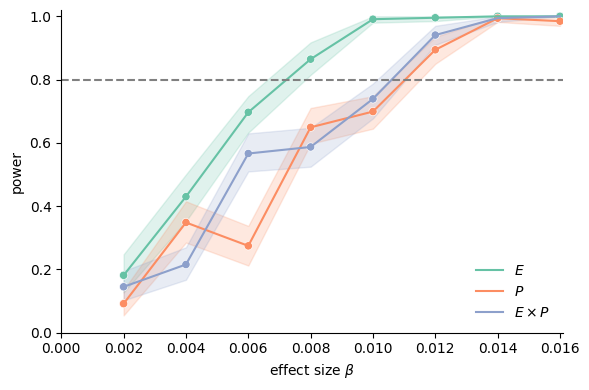

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=power_bootstrap,
    ax=ax,
    x="effect", 
    y="power",
    hue="variable",
    errorbar="pi",
    palette="Set2",
)

sns.scatterplot(
    data=power_bootstrap.groupby(["variable", "effect"]).mean().reset_index(),
    ax=ax,
    x="effect",
    y="power",
    hue="variable",
    hue_order=["$E$", "$P$", "$E \\times P$"],
    sizes=[50, 50, 50],
    palette="Set2",
    legend=False
)

ax.set_xlabel("effect size $\\beta$")
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False)
ax.plot([0, 0.0161], [0.8, 0.8], '--', color="grey")
ax.set_xlim(0, 0.0161)
ax.set_ylim(0, 1.02)
plt.tight_layout()

#fname = "power_analysis_elections_belief-speaking"
#plt.savefig(Path(plt_dst, fname + ".pdf"))
#plt.savefig(Path(plt_dst, fname + ".svg"))

## Power analysis fact-speaking

### Linear mixed-effects model simulations

In [14]:
# define simulation parameters
n_sim = 100  # Number of simulations
alpha = 0.05  # Significance level

# sample sizes
n_groups = len(candidates)
n_democrats = len(candidates[candidates["PARTY"] == "D"])
mean_tweets_before = candidates["N_tweets_before"].mean()
mean_tweets_after = candidates["N_tweets_after"].mean()

# variance components - from script estimate_variance_factors_pilot_data.ipynb
variance_components = {}
fname = "variance_components_election_analysis_fact_speaking.txt"
with open(Path(dst, "variance_components", fname), "r") as infile:
    for line in infile:
        key, val = line.rstrip().split("=")
        variance_components[key] = float(val)
    
var_intercept = variance_components["var_intercept"]
var_slope_E = variance_components["var_slope_E"]
cov_intercept_slope_E = variance_components["cov_intercept_slope_E"]
var_residual = variance_components["var_residual"]

In [15]:
beta_Es = [0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016]
beta_Ps = [0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016]
beta_EPs = [0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016]
random_states = range(n_sim)

params = [(i, beta_Es[j], beta_Ps[j], beta_EPs[j])\
              for j in range(len(beta_Es))\
              for i in random_states] 
N_configs = len(params)

In [ ]:
results = pd.DataFrame()
pool = Pool(10)

for tmp1, tmp2, tmp3, tmp4, tmp5, tmp6, tmp7 in tqdm(pool.imap_unordered(
    func=simulate_lme, 
    iterable=params), 
    total=N_configs):

    results = pd.concat([results, pd.DataFrame({
        "random_state":[tmp1],
        "beta_E":[tmp2],
        "beta_P":[tmp3],
        "beta_EP":[tmp4],
        "p_value_E":[tmp5],
        "p_value_P":[tmp6],
        "p_value_EP":[tmp7]
    })])

pool.close()

results["alpha"] = alpha
results["var_intercept"] = var_intercept
results["var_residual"] = var_residual
fname = "elections_fact-speaking_power_analysis.csv"
results.to_csv(Path(dst, fname), index=False)

### Calculate power

In [18]:
# calculate power bootstrapped
fname = "elections_fact-speaking_power_analysis.csv"
results = pd.read_csv(Path(dst, fname))
power_bootstrap = pd.DataFrame()

n_bootstrap = 100
for beta_E, beta_P, beta_EP in zip(beta_Es, beta_Ps, beta_EPs):
    for n in range(n_bootstrap):
        res = results[
            (results["beta_E"] == beta_E) & \
            (results["beta_P"] == beta_P) & \
            (results["beta_EP"] == beta_EP)
        ].sample(frac=1, replace=True)
    
        power_E = np.nanmean(res["p_value_E"].values < alpha)
        power_P = np.nanmean(res["p_value_P"].values < alpha)
        power_EP = np.nanmean(res["p_value_EP"].values < alpha)
        
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$E$"],
            "effect":[beta_E],
            "power":[power_E],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$P$"],
            "effect":[beta_P],
            "power":[power_P],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$E \\times P$"],
            "effect":[beta_EP],
            "power":[power_EP]
        })])

### Visualisation of power analysis

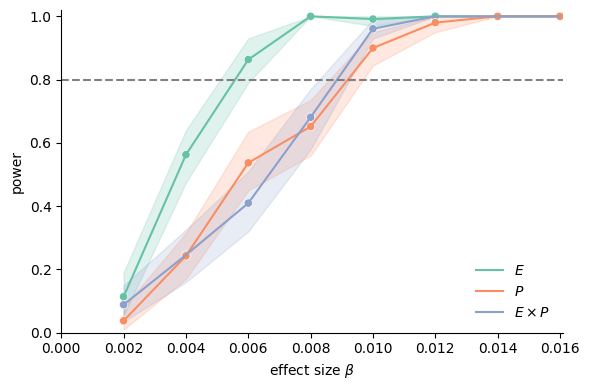

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=power_bootstrap,
    ax=ax,
    x="effect", 
    y="power",
    hue="variable",
    errorbar="pi",
    palette="Set2",
)

sns.scatterplot(
    data=power_bootstrap.groupby(["variable", "effect"]).mean().reset_index(),
    ax=ax,
    x="effect",
    y="power",
    hue="variable",
    hue_order=["$E$", "$P$", "$E \\times P$"],
    sizes=[50, 50, 50],
    palette="Set2",
    legend=False
)

ax.set_xlabel("effect size $\\beta$")
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False)
ax.plot([0, 0.0161], [0.8, 0.8], '--', color="grey")
ax.set_xlim(0, 0.0161)
ax.set_ylim(0, 1.02)
plt.tight_layout()

#fname = "power_analysis_elections_fact-speaking"
#plt.savefig(Path(plt_dst, fname + ".pdf"))
#plt.savefig(Path(plt_dst, fname + ".svg"))

## Power analysis double-panel figure

In [20]:
# calculate power bootstrapped
fname = "elections_belief-speaking_power_analysis.csv"
results = pd.read_csv(Path(dst, fname))
power_bootstrap_belief = pd.DataFrame()

n_bootstrap = 100
for beta_E, beta_P, beta_EP in zip(beta_Es, beta_Ps, beta_EPs):
    for n in range(n_bootstrap):
        res = results[
            (results["beta_E"] == beta_E) & \
            (results["beta_P"] == beta_P) & \
            (results["beta_EP"] == beta_EP)
        ].sample(frac=1, replace=True)
    
        power_E = np.nanmean(res["p_value_E"].values < alpha)
        power_P = np.nanmean(res["p_value_P"].values < alpha)
        power_EP = np.nanmean(res["p_value_EP"].values < alpha)
        
        power_bootstrap_belief = pd.concat([power_bootstrap_belief, pd.DataFrame({
            "variable":["$E$"],
            "effect":[beta_E],
            "power":[power_E],
        })])
        power_bootstrap_belief = pd.concat([power_bootstrap_belief, pd.DataFrame({
            "variable":["$P$"],
            "effect":[beta_P],
            "power":[power_P],
        })])
        power_bootstrap_belief = pd.concat([power_bootstrap_belief, pd.DataFrame({
            "variable":["$E \\times P$"],
            "effect":[beta_EP],
            "power":[power_EP]
        })])

In [21]:
# calculate power bootstrapped
fname = "elections_fact-speaking_power_analysis.csv"
results = pd.read_csv(Path(dst,fname))
power_bootstrap_fact = pd.DataFrame()

n_bootstrap = 100
for beta_E, beta_P, beta_EP in zip(beta_Es, beta_Ps, beta_EPs):
    for n in range(n_bootstrap):
        res = results[
            (results["beta_E"] == beta_E) & \
            (results["beta_P"] == beta_P) & \
            (results["beta_EP"] == beta_EP)
        ].sample(frac=1, replace=True)
    
        power_E = np.nanmean(res["p_value_E"].values < alpha)
        power_P = np.nanmean(res["p_value_P"].values < alpha)
        power_EP = np.nanmean(res["p_value_EP"].values < alpha)
        
        power_bootstrap_fact = pd.concat([power_bootstrap_fact, pd.DataFrame({
            "variable":["$E$"],
            "effect":[beta_E],
            "power":[power_E],
        })])
        power_bootstrap_fact = pd.concat([power_bootstrap_fact, pd.DataFrame({
            "variable":["$P$"],
            "effect":[beta_P],
            "power":[power_P],
        })])
        power_bootstrap_fact = pd.concat([power_bootstrap_fact, pd.DataFrame({
            "variable":["$E \\times P$"],
            "effect":[beta_EP],
            "power":[power_EP]
        })])

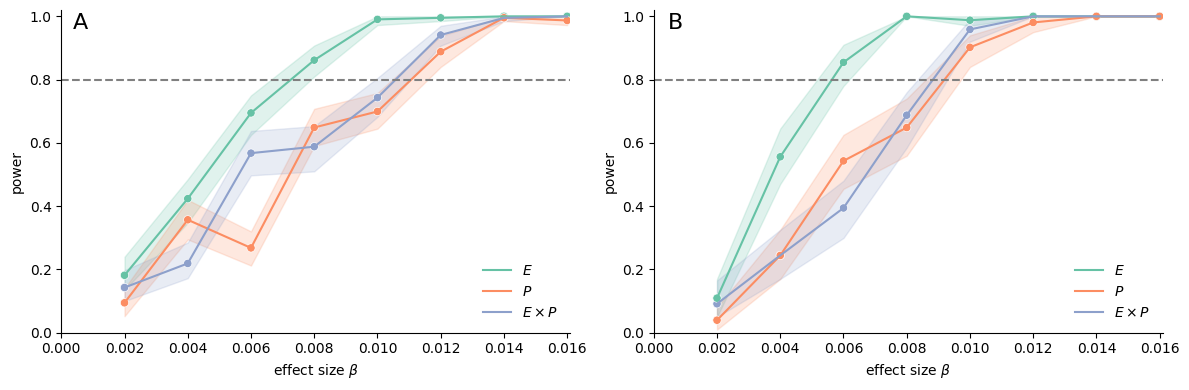

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    data=power_bootstrap_belief,
    ax=axes[0],
    x="effect", 
    y="power",
    hue="variable",
    errorbar="pi",
    palette="Set2",
)

sns.scatterplot(
    data=power_bootstrap_belief.groupby(["variable", "effect"]).mean().reset_index(),
    ax=axes[0],
    x="effect",
    y="power",
    hue="variable",
    hue_order=["$E$", "$P$", "$E \\times P$"],
    sizes=[50, 50, 50],
    palette="Set2",
    legend=False
)

sns.lineplot(
    data=power_bootstrap_fact,
    ax=axes[1],
    x="effect", 
    y="power",
    hue="variable",
    errorbar="pi",
    palette="Set2",
)

sns.scatterplot(
    data=power_bootstrap_fact.groupby(["variable", "effect"]).mean().reset_index(),
    ax=axes[1],
    x="effect",
    y="power",
    hue="variable",
    hue_order=["$E$", "$P$", "$E \\times P$"],
    sizes=[50, 50, 50],
    palette="Set2",
    legend=False
)

for ax in axes:
    ax.set_xlabel("effect size $\\beta$")
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend(frameon=False)
    ax.plot([0, 0.0161], [0.8, 0.8], '--', color="grey")
    ax.set_xlim(0, 0.0161)
    ax.set_ylim(0, 1.02)

fig.text(0.065, 0.915, "A", fontsize=16)
fig.text(0.561, 0.915, "B", fontsize=16)
plt.tight_layout()

fname = "power_analysis_elections"
plt.savefig(Path(plt_dst, fname + ".pdf"))
plt.savefig(Path(plt_dst, fname + ".svg"))

## Main analysis

TODO